In [1]:
%matplotlib inline


In [2]:
import torch
import matplotlib.pyplot as plt
import torchvision
import nengolib
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm_notebook
from deepsith import DeepSITH
import PIL
from torch.nn.utils import weight_norm

from os.path import join
import scipy.special
import pandas as pd
import seaborn as sn
import scipy
from scipy.spatial.distance import euclidean
from scipy.interpolate import interp1d
from tqdm.notebook import tqdm
import random
from csv import DictWriter
# if gpu is to be used
use_cuda = torch.cuda.is_available()
FloatTensor = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor
DoubleTensor = torch.cuda.DoubleTensor if use_cuda else torch.DoubleTensor

IntTensor = torch.cuda.IntTensor if use_cuda else torch.IntTensor
LongTensor = torch.cuda.LongTensor if use_cuda else torch.LongTensor
ByteTensor = torch.cuda.ByteTensor if use_cuda else torch.ByteTensor
ttype = FloatTensor

import seaborn as sns
print(use_cuda)
import pickle


True


In [3]:
sn.set_context("poster")

# Load Stimuli

In [4]:
import collections

def mackey_glass(sample_len=1000, tau=17, delta_t=10, seed=None, n_samples=1):
    # Adapted from https://github.com/mila-iqia/summerschool2015/blob/master/rnn_tutorial/synthetic.py
    '''
    mackey_glass(sample_len=1000, tau=17, seed = None, n_samples = 1) -> input
    Generate the Mackey Glass time-series. Parameters are:
        - sample_len: length of the time-series in timesteps. Default is 1000.
        - tau: delay of the MG - system. Commonly used values are tau=17 (mild 
          chaos) and tau=30 (moderate chaos). Default is 17.
        - seed: to seed the random generator, can be used to generate the same
          timeseries at each invocation.
        - n_samples : number of samples to generate
    '''
    history_len = tau * delta_t 
    # Initial conditions for the history of the system
    timeseries = 1.2
    
    if seed is not None:
        np.random.seed(seed)

    samples = []

    for _ in range(n_samples):
        history = collections.deque(1.2 * np.ones(history_len) + 0.2 * \
                                    (np.random.rand(history_len) - 0.5))
        # Preallocate the array for the time-series
        inp = np.zeros((sample_len,1))
        
        for timestep in range(sample_len):
            for _ in range(delta_t):
                xtau = history.popleft()
                history.append(timeseries)
                timeseries = history[-1] + (0.2 * xtau / (1.0 + xtau ** 10) - \
                             0.1 * history[-1]) / delta_t
            inp[timestep] = timeseries
        
        # Squash timeseries through tanh
        inp = np.tanh(inp - 1)
        samples.append(inp)
    return samples


def generate_data(n_batches, length, split=0.5, seed=0,
                  predict_length=15, tau=17, washout=100, delta_t=1,
                  center=True):
    X = np.asarray(mackey_glass(
        sample_len=length+predict_length+washout, tau=tau,
        seed=seed, n_samples=n_batches))
    X = X[:, washout:, :]
    cutoff = int(split*n_batches)
    if center:
        X -= np.mean(X)  # global mean over all batches, approx -0.066
    Y = X[:, predict_length:, :]
    X = X[:, :-predict_length, :]
    assert X.shape == Y.shape
    return ((X[:cutoff], Y[:cutoff]),
            (X[cutoff:], Y[cutoff:]))

In [5]:
(train_X, train_Y), (test_X, test_Y) = generate_data(128, 5000)

dataset = torch.utils.data.TensorDataset(torch.Tensor(train_X).cuda(), torch.Tensor(train_Y).cuda())
dataset = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True)

dataset_valid = torch.utils.data.TensorDataset(torch.Tensor(test_X).cuda(), torch.Tensor(test_Y).cuda())
dataset_valid = torch.utils.data.DataLoader(dataset_valid, batch_size=64, shuffle=False)


## Setup for Model

In [16]:

def train(model, ttype, train_loader, test_loader, optimizer, loss_func, epoch, perf_file,
          loss_buffer_size=800, batch_size=4, device='cuda',
          prog_bar=None):
    
    assert(loss_buffer_size%batch_size==0)
        
    losses = []
    last_test_perf = 0
    best_test_perf = -1
    
    for batch_idx, (data, target) in enumerate(train_loader):
        model.train()
        data = data.to(device).view(data.shape[0],1,1,-1)
        target = target.to(device)
        optimizer.zero_grad()
        out = model(data)
        loss = loss_func(out,
                         target)

        loss.backward()
        optimizer.step()

        losses.append(loss.detach().cpu().numpy())
        losses = losses[int(-loss_buffer_size/batch_size):]
        
        if ((batch_idx*batch_size)%loss_buffer_size == 0):
            loss_track = {}
            last_test_perf = test_model(model, 'cuda', test_loader, 
                                  )
            loss_track['avg_loss'] = np.mean(losses)
            loss_track['last_test'] = last_test_perf
            loss_track['epoch'] = epoch
            loss_track['batch_idx'] = batch_idx
            with open(perf_file, 'a+') as fp:
                csv_writer = DictWriter(fp, fieldnames=list(loss_track.keys()))
                if fp.tell() == 0:
                    csv_writer.writeheader()
                csv_writer.writerow(loss_track)
                fp.flush()
            if best_test_perf > last_test_perf:
                torch.save(model.state_dict(), perf_file[:-4]+".pt")
                best_test_perf = last_test_perf
        if not (prog_bar is None):
            # Update progress_bar
            s = "{}:{} Loss: {:.4f}, valid: {:.4f}"
            format_list = [e,batch_idx*batch_size, np.mean(losses), 
                           last_test_perf]         
            s = s.format(*format_list)
            prog_bar.set_description(s)
                
def test_model(model, device, test_loader):
    # Test the Model
    nrmsd = []
    with torch.no_grad():
        for x, y in test_loader:
            data = x.to(device).view(x.shape[0],1,1,-1)
            target = y.to(device)
            optimizer.zero_grad()
            out = model(data)
            nrmsd.append(nengolib.signal.nrmse(out.detach().cpu().numpy().flatten(), 
                                               target=target.detach().cpu().numpy().flatten()))

    perf = np.array(nrmsd).mean()
    return perf

In [17]:

    
class DeepSITH_Tracker(nn.Module):
    def __init__(self, out, layer_params, dropout=.5):
        super(DeepSITH_Tracker, self).__init__()
        last_hidden = layer_params[-1]['hidden_size']
        self.hs = DeepSITH(layer_params=layer_params, dropout=dropout)
        self.to_out = nn.Linear(last_hidden, out)
    def forward(self, inp):
        x = self.hs(inp)
        #x = torch.tanh(self.to_out(x))
        x = self.to_out(x)
        return x

In [32]:
# Rule 1.1: The first layer's taustar has to have non-overlap of dt and 2dt. 
# Rule 1.2: 
# Rule 2.0: Over all other taustars, take the sum of the filters at g=1, 
#         STD around the middle, needs to be close to close to 0.0
# 
sith_params1 = {"in_features":1, 
                "tau_min":1, "tau_max":25.0, 
                "k":15, 'dt':1,
                "ntau":8, 'g':0.0,  
                "ttype":ttype, 'batch_norm':False,
                "hidden_size":25, "act_func":nn.ReLU()}
sith_params2 = {"in_features":sith_params1['hidden_size'], 
                "tau_min":1, "tau_max":50.0, 
                "k":8, 'dt':1,
                "ntau":8, 'g':0.0, 
                "ttype":ttype, 'batch_norm':False,
                "hidden_size":25, "act_func":nn.ReLU()}
sith_params3 = {"in_features":sith_params2['hidden_size'], 
                "tau_min":1, "tau_max":150.0, 'buff_max':600, 
                "k":4, 'dt':1,
                "ntau":8, 'g':0.0, 
                "ttype":ttype, 'batch_norm':False,
                "hidden_size":25, "act_func":nn.ReLU()}
layer_params = [sith_params1, sith_params2, sith_params3]

model = DeepSITH_Tracker(out=1,
                         layer_params=layer_params, 
                         dropout=0.).cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=.0045)
loss_func = nn.MSELoss()

tot = 0
for p in model.parameters():
    tot += p.numel()
print("tot_weights", tot)
print(model)

tot_weights 10301
DeepSITH_Tracker(
  (hs): DeepSITH(
    (layers): ModuleList(
      (0): _DeepSITH_core(
        (sith): iSITH(ntau=8, tau_min=1, tau_max=25.0, buff_max=75.0, dt=1, k=15, g=0.0)
        (linear): Linear(in_features=8, out_features=25, bias=True)
        (act_func): ReLU()
      )
      (1): _DeepSITH_core(
        (sith): iSITH(ntau=8, tau_min=1, tau_max=50.0, buff_max=150.0, dt=1, k=8, g=0.0)
        (linear): Linear(in_features=200, out_features=25, bias=True)
        (act_func): ReLU()
      )
      (2): _DeepSITH_core(
        (sith): iSITH(ntau=8, tau_min=1, tau_max=150.0, buff_max=600, dt=1, k=4, g=0.0)
        (linear): Linear(in_features=200, out_features=25, bias=True)
        (act_func): ReLU()
      )
    )
    (dropouts): ModuleList(
      (0): Dropout(p=0.0, inplace=False)
      (1): Dropout(p=0.0, inplace=False)
    )
  )
  (to_out): Linear(in_features=25, out_features=1, bias=True)
)


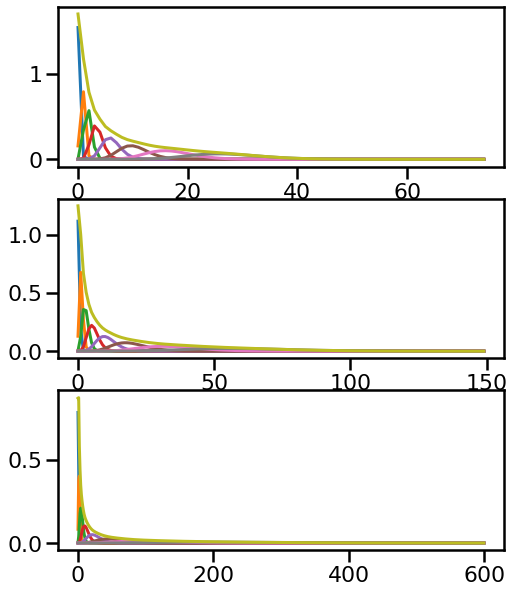

In [33]:
fig = plt.figure(figsize=(8,10))

ax = fig.add_subplot(3,1,1)
ax.plot(model.hs.layers[0].sith.filters[:, 0, 0, :].detach().cpu().T.numpy()[::-1],
       );
ax.plot(model.hs.layers[0].sith.filters[:, 0, 0, :].detach().cpu().T.numpy()[::-1].sum(1),
        );
ax = fig.add_subplot(3,1,2)
ax.plot(model.hs.layers[1].sith.filters[:, 0, 0, :].detach().cpu().T.numpy()[::-1],
        );
ax.plot(model.hs.layers[1].sith.filters[:, 0, 0, :].detach().cpu().T.numpy()[::-1].sum(1),
        );
ax = fig.add_subplot(3,1,3)
ax.plot(model.hs.layers[2].sith.filters[:, 0, 0, :].detach().cpu().T.numpy()[::-1],
        );
ax.plot(model.hs.layers[2].sith.filters[:, 0, 0, :].detach().cpu().T.numpy()[::-1].sum(1),
        );

In [34]:

epochs = 1000
batch_size = 32
progress_bar = tqdm(range(int(epochs)), bar_format='{l_bar}{bar:5}{r_bar}{bar:-5b}')
last_perf = 1000
for e in progress_bar:
    train(model, ttype, dataset, dataset_valid, 
          optimizer, loss_func, batch_size=batch_size, loss_buffer_size=64,
          epoch=e, perf_file=join('perf','mackeyglass_deepsith_22.csv'),
          prog_bar=progress_bar)

In [31]:
import nengolib

In [ ]:
X, Y = next(iter(dataset_valid))
out = model(X.to('cuda').view(X.shape[0],1,1,-1))

In [45]:
nengolib.signal.nrmse(out.detach().cpu().numpy().flatten(), target=Y.detach().cpu().numpy().flatten())

0.014051615

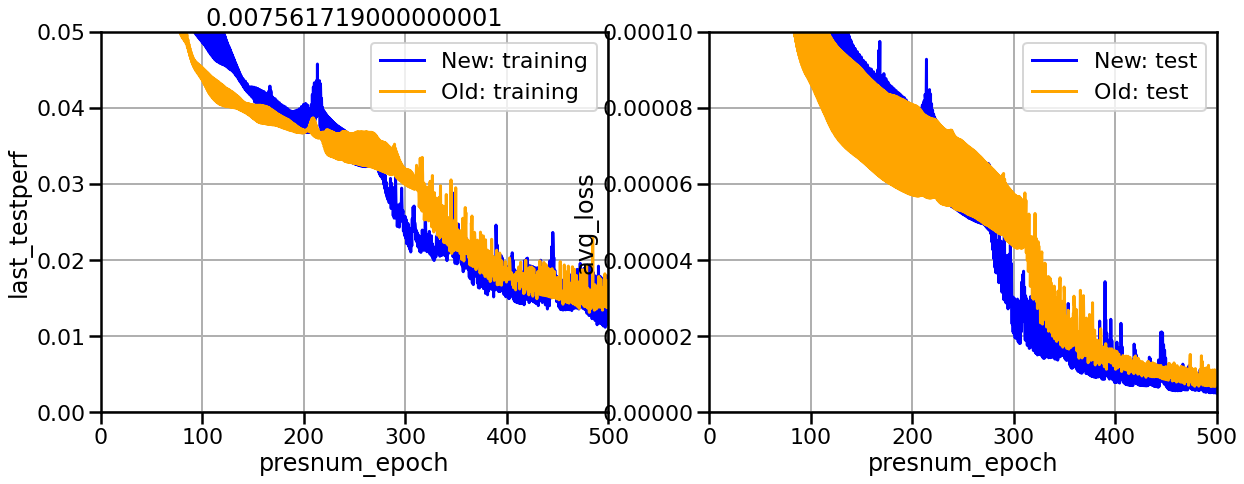

In [6]:
dat = pd.read_csv(join('perf', 'mackeyglass_deepsith_.csv'))
maxpres = 64
dat['presnum_epoch'] = ((dat.batch_idx) + maxpres*dat.epoch)/maxpres


fig = plt.figure(figsize=(20,7))
ax = fig.add_subplot(1,2,1)
sn.lineplot(data=dat, x=dat.presnum_epoch, y='last_testperf', 
            color='blue', ax=ax)

ax.grid(True)
ax.set_title(dat.last_testperf.min())
ax.legend(["Training", 
           ])
ax.set_xlim(0, 500)
ax.set_ylim(.00, .05)
ax = fig.add_subplot(1,2,2)
sn.lineplot(data=dat, x=dat.presnum_epoch, y='avg_loss', 
            color='blue',ax=ax)

ax.set_xlim(0, 500)
ax.set_ylim(.00, .0001)
ax.legend(["Test NRMSD"])
ax.grid(True)


In [2]:
import pickle

In [3]:
with open('LMU_data.dil', 'rb') as f:
    dats = pickle.load(f)

FileNotFoundError: [Errno 2] No such file or directory: 'LMU_data.dil'

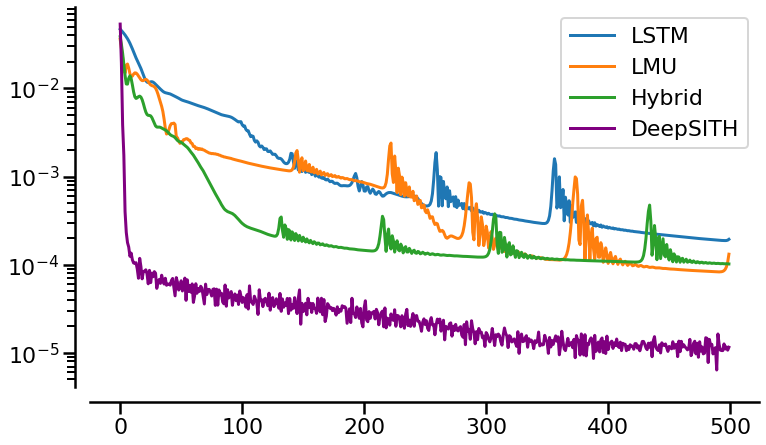

In [29]:
fig = plt.figure(figsize=(12,7))

plt.plot(np.arange(0, 500, 1), dats[0], linewidth=3)
plt.plot(np.arange(0, 500, 1), dats[1], linewidth=3)
plt.plot(np.arange(0, 500, 1), dats[2], linewidth=3)
plt.plot(np.arange(0, 500, 1), perf['loss'][::32], color='purple', linewidth=3)
plt.yscale('log')
plt.legend(['LSTM', 'LMU', 'Hybrid', 'DeepSITH'])
plt.savefig('performance')
sns.despine(offset=15)
plt.savefig('mackey_glass_perf', dpi=200)

In [ ]:
# Impulse-based SITH class
class iSITH():
    def __init__(self, tau_min=.1, tau_max=20., buff_max=100, k=8, ntau=10, dt=.01, g=0.0):
        # save inputs
        self.k = k
        self.tau_min = tau_min
        self.tau_max = tau_max
        self.ntau = ntau
        self.dt = dt
        self.g = g        # calc tau_star
        self.c = (self.tau_max/self.tau_min)**(1./(ntau-1))-1
        self.tau_star = self.tau_min * (1 + self.c)**np.arange(ntau)        # determine the time points in steps of dt
        self.times = np.arange(dt, buff_max+dt, dt)        # fill the ftilde filters
        a = np.log(k)*k
        b = np.log(np.arange(2,k)).sum()
        A = ((1/self.tau_star)*(np.exp(a-b))*(self.tau_star**self.g))[:, np.newaxis]
        self.filters = A*np.exp((np.log(self.times[np.newaxis, :]/self.tau_star[:, np.newaxis])*(k+1)) + \
                                (k*(-self.times[np.newaxis, :]/self.tau_star[:, np.newaxis])))        #A = ((1/self.tau_star)*(k**(k)/factorial(k-1))*(self.tau_star**self.g))[:, np.newaxis]
        #self.filters = A*((self.times[np.newaxis, :]/self.tau_star[:, np.newaxis])**(k+1)) * \
        #                np.exp(k*(-self.times[np.newaxis, :]/self.tau_star[:, np.newaxis]))    def present(self, x):
        # make sure input is features by time
        x = np.atleast_2d(x)        # get num points to save from the convolution
        xlen = x.shape[-1]        # loop over features and taustars performing the convolution
        # note we're scaling the output by both dt and the k/(k+1)
        return np.array([[signal.convolve(self.filters[i], x[j])[:xlen]
                            for i in range(len(self.filters))]
                         for j in range(len(x))])*self.dt*self.k/(self.k+1)

Normalized RMSD: 0.023245052


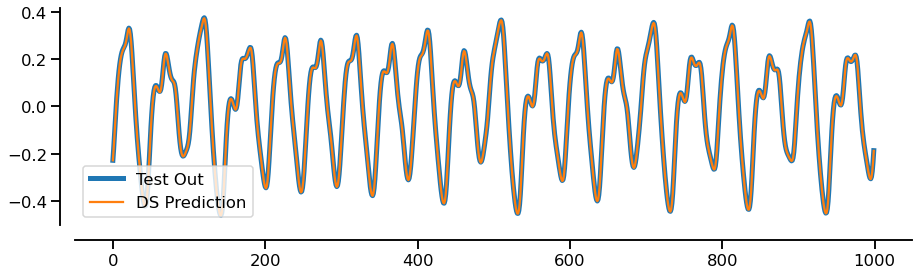

In [21]:
model.eval()
fig = plt.figure(figsize=(15,4))

idx = 9
out = model(test_X[idx].view(1,1,1,-1))[0]
plt.plot(test_Y[idx][-1000:].detach().cpu().numpy(), linewidth=5)
plt.plot(out[-1000:].detach().cpu().numpy())
plt.legend(['Test Out', 'DS Prediction'])
model.train();
print('Normalized RMSD:', np.sqrt(((test_Y[idx].detach().cpu().numpy() - out.detach().cpu().numpy())**2).mean()/
                                  (test_Y[idx].detach().cpu().numpy()**2).mean()))
sns.despine(offset=15)

plt.savefig('long_boy')

Normalized RMSD: 0.021320727


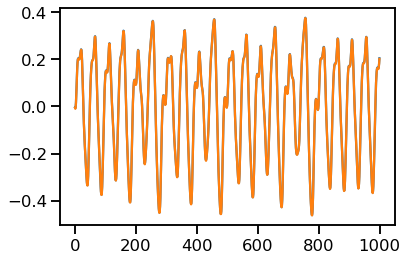

In [22]:
model.eval()
out = model(train_X[idx].view(1,1,1,-1))[0]
plt.plot(train_Y[idx][-1000:].detach().cpu().numpy())
plt.plot(out[-1000:].detach().cpu().numpy())
model.train();
print('Normalized RMSD:', np.sqrt(((train_Y[idx].detach().cpu().numpy() - out.detach().cpu().numpy())**2).mean()/
                                  (train_Y[idx].detach().cpu().numpy()**2).mean()))

In [23]:
model.eval()
nrmsd = []
for idx in range(test_X.shape[0]):
    out = model(test_X[idx].view(1,1,1,-1))[0]
    nrmsd.append(np.sqrt(((test_Y[idx].detach().cpu().numpy() - out.detach().cpu().numpy())**2).mean()/
                                  (test_Y[idx].detach().cpu().numpy()**2).mean()))
model.train();
i
print('Avg Normalized RMSD:', np.array(nrmsd).mean())

NameError: name 'i' is not defined

In [24]:
model.eval()
def_scale = 5000
res = {'nrmsd':[],
       'sig_leng':[]}
for num in range(1000, 10000, 500):
    nrmsd = []
    #_, (test_X, test_Y) = generate_data(128, num)
    #train_X = ttype(train_X).view(64, 1, 1, num)
    #train_Y = ttype(train_Y).view(64, num, 1)
    #test_Xhalf = ttype(test_X).view(64, 1, 1, num)
    #test_Yhalf = ttype(test_Y).view(64, num, 1)
    for idx in range(test_X.shape[0]):
        f = scipy.interpolate.interp1d(np.arange(0, def_scale, 1),
                                       test_X[idx].view(-1).detach().cpu())
        new_X = f(np.arange(0, def_scale-1*(num/def_scale), 1/(num/def_scale)))
        
        f = scipy.interpolate.interp1d(np.arange(0, def_scale, 1),
                                       test_Y[idx].view(-1).detach().cpu())
        new_Y = f(np.arange(0, def_scale-1*(num/def_scale), 1/(num/def_scale)))
        
        out = model(ttype(new_X).view(1,1,1,-1))[0]
        nrmsd.append(np.sqrt(((new_Y - out.view(-1).detach().cpu().numpy())**2).mean()/
                                      (new_Y**2).mean()))
    res['nrmsd'].append(np.array(nrmsd).mean())
    res['sig_leng'].append(num)
    print('Avg Normalized RMSD at {}:'.format(num), np.array(nrmsd).mean())
model.train();
dat = pd.DataFrame(res)
dat.to_pickle("DS_RES_MG.dill")

Avg Normalized RMSD at 1000: 0.972260558871721
Avg Normalized RMSD at 1500: 0.9091545694442643
Avg Normalized RMSD at 2000: 0.9443043088703369
Avg Normalized RMSD at 2500: 0.8151543524082685
Avg Normalized RMSD at 3000: 0.6243459816755677
Avg Normalized RMSD at 3500: 0.43018593206602856
Avg Normalized RMSD at 4000: 0.2679400108095559
Avg Normalized RMSD at 4500: 0.1294783924551375
Avg Normalized RMSD at 5000: 0.015388177716885512
Avg Normalized RMSD at 5500: 0.11554172073777101
Avg Normalized RMSD at 6000: 0.20531042933892588
Avg Normalized RMSD at 6500: 0.2815575471728947
Avg Normalized RMSD at 7000: 0.35691322422016086
Avg Normalized RMSD at 7500: 0.43314959408021136
Avg Normalized RMSD at 8000: 0.5078215846760346
Avg Normalized RMSD at 8500: 0.5764260431094455
Avg Normalized RMSD at 9000: 0.6367769073075698
Avg Normalized RMSD at 9500: 0.6862401255435326


In [5]:
dat_2 = pd.read_pickle(open("LOLA_RES_MG.dill", 'rb'))
dat = pd.read_pickle(open("DS_RES_MG.dill", 'rb'))


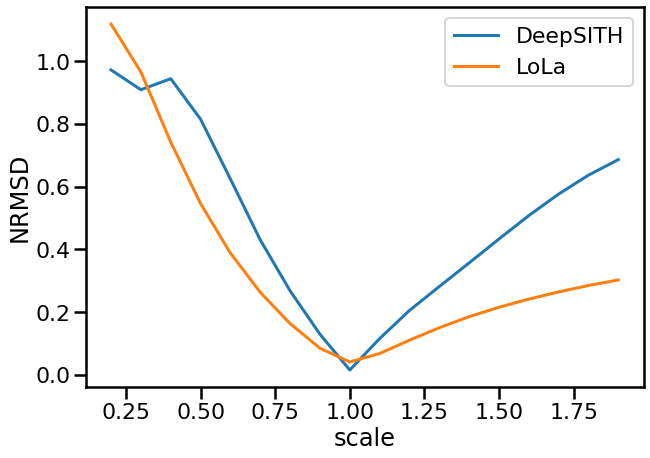

In [10]:
fig = plt.figure(figsize=(10,7))

plt.plot(np.arange(1000, 9600, 500)/5000, dat['nrmsd'])
plt.plot(np.arange(1000, 9600, 500)/5000, dat_2['nrmsd'])
plt.legend(['DeepSITH', 'LoLa'])
plt.xlabel("scale")
plt.ylabel("NRMSD")
plt.savefig("LoLavsDS")